In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# %load_ext lab_black
%load_ext Cython

In [3]:
import pyximport

pyximport.install()

from hue_mask import hue_mask, mask_circle

In [4]:
%%cython
# %%cython -a

import math
import cython

cdef float _bandpass_lookup[256]
cdef float _last_sigma = 0.0
cdef float _last_gain = 0.0
cdef unsigned char _last_center = 0

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _update_bandpass_lookup(unsigned char center, float sigma, float gain):
    global _bandpass_lookup
    global _last_center
    global _last_gain
    global _last_sigma
    # cdef float h

    _last_center = center
    _last_sigma = sigma
    _last_gain = gain

    mu = 0.5
    for n in range(256):
        h = n / 255.0

        # rotate the hue phase so that `center` is at 0.5
        h = h + (0.5 - (center / 255.0))
        if (h > 1.0):
            h = h - 1.0
        if (h < 0.0):
            h = h + 1.0

        # gaussian bandpass filter
        f = math.exp(-( (h - mu)**2 / ( 2.0 * sigma**2 ) ) )

        # pre-gain around center
        f = f * gain
        if f > 1.0:
            f = 1.0

        _bandpass_lookup[n] = f


@cython.boundscheck(False)
@cython.wraparound(False)
# hue_mask(img_hsv, hue / 2, 0.05, 12.0, 4.0)
def hue_mask(unsigned char [:, :, :] image, unsigned char center, float sigma, float gain, float mask_gain):
    global _bandpass_lookup

    # set the variable extension types
    cdef int x, y, n, width, height
    cdef float h, s, v, mu, f
    cdef unsigned char mask, ih

    # grab the image dimensions
    height = image.shape[0]
    width = image.shape[1]

    # generate a lookup table for center, sigma & gain
    if (center != _last_center or sigma != _last_sigma or gain != _last_gain):
        _update_bandpass_lookup(center, sigma, gain)

    for y in range(0, height):
        for x in range(0, width):
            # pull each component out as a float [0..1]
            ih = image[y, x, 0]
            s = image[y, x, 1] / 255.0
            v = image[y, x, 2] / 255.0

            # map from [0..255] -> [0..1] through lookup table
            # this applies the bandpass filter on hue
            h = _bandpass_lookup[ih]

            # mask the hue with sat, val and apply another gain filter
            f = (h * s * v) * mask_gain
            if f > 1.0:
                f = 1.0

            # covert back to char space
            mask = <unsigned char>(f * 255)
            image[y, x, 0] = mask
            image[y, x, 1] = mask
            image[y, x, 2] = mask

    # return the thresholded image
    return image

In [5]:
dataset_files = {}

for root, dirs, files in os.walk("dataset/"):
    name = root.replace("dataset/", "")
    if name:
        dataset_files[name] = [root + "/" + f for f in files if f.find(".jpg") != -1]

In [6]:
colors = (
    "no-ball",
    "orange",
    "yellow",
    "green",
    "blue",
    "pink",
    "purple",
    #'glow-in-the-dark',
)
hues = {
    "no-ball": 55,
    "orange": 55,
    "yellow": 65,
    "green": 125,
    "blue": 200,
    "pink": 325,
    "purple": 300,
    "glow-in-the-dark": 125,
}

In [7]:
def display(im):
    """Display a gray image or BGR image with maplotlib (which usually takes RGB)."""
    sh = im.shape
    if len(sh) == 3 and sh[2] != 1:
        plt.imshow(im[:, :, ::-1])
    else:
        plt.imshow(im, cmap="gray", vmin=0, vmax=255)
    plt.show()

### Mask circle (Cython)

In [8]:
%%cython

import math
import cython
# cimport math

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _mask_circle(unsigned char [:, :, :] image, int center_x, int center_y, int radius, int mask_shade):
    # set the variable extension types
    cdef int x, y, dist, square_dist

    # grab the image dimensions
    height = image.shape[0]
    width = image.shape[1]

    center_x = width / 2
    center_y = height / 2

    for y in range(0, height):
        for x in range(0, width):
            square_dist = (x - center_x)**2 + (y - center_y)**2
            dist = math.sqrt(square_dist) 
            if dist > radius:
                image[y, x, 0] = mask_shade
                image[y, x, 1] = mask_shade
                image[y, x, 2] = mask_shade
                
    return image

def mask_circle(image, x, y, radius, mask_shade=0):
    _mask_circle(image, x, y, radius, mask_shade)
    return image

### Soft Mask (Cython)

In [9]:
%%cython

cimport numpy as np
import numpy as np
import math
import cython
# cimport math

cdef cmin(double a, double b):
    if a < b:
        return a
    else:
        return b

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _soft_mask(unsigned char [:, :, :] image, unsigned char [:, :] mask, double contrast_gain):
    cdef int x, y, b, g, r

    # grab the image dimensions
    height = image.shape[0]
    width = image.shape[1]
    m_height = mask.shape[0]
    m_width = mask.shape[1]

    if (height != m_height) or (width != m_width):
        return -1

    for y in range(0, height):
        for x in range(0, width):
            b = cmin(<double> image[y, x, 0] * contrast_gain * <double> mask[y, x] / 256, 256)
            g = cmin(<double> image[y, x, 1] * contrast_gain * <double> mask[y, x] / 256, 256)
            r = cmin(<double> image[y, x, 2] * contrast_gain * <double> mask[y, x] / 256, 256)
            image[y, x, 0] = <unsigned char> b
            image[y, x, 1] = <unsigned char> g
            image[y, x, 2] = <unsigned char> r
                
    return np.asarray(image)

def soft_mask(img, mask, contrast_gain=1.0):
    return _soft_mask(img, mask, contrast_gain)

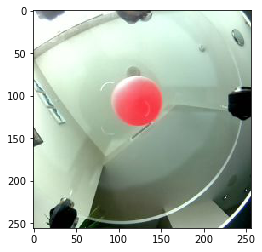

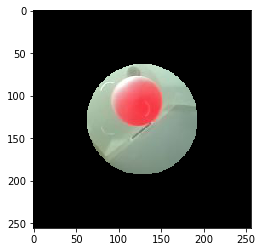

In [15]:
# Test mask_circle
im = cv2.imread(np.random.choice(dataset_files[np.random.choice(colors, 1)[0]], 1)[0])
display(im)
display(mask_circle(im, 128, 128, 256 / 4))

### average_color_circle

In [16]:
def average_color_circle(img, circle, crop_square=False):
    """
    Calculate the average hue inside a circle.

    crop_square: Instead of calculating the average hue of a circle, calculate
                 the average hue of a sqaure that is bounded by the given circle.
                 This is `probably` faster.
    """
    if crop_square:
        # Crop a square that stricly encloses the circle (square is larger than
        # circle), the smallest such square has a side length that is equal to
        # the diameter (2 * radius) of the circle.
        x, y, radius = circle
        crop = img[y - radius : y + radius, x - radius : x + radius, :]

        # Set the pixels outside of the radius of the circle to white (masking
        # the pixels outside of the circle), finally calculate the average
        # color by subtracting the effect of the masked (white) pixels.
        masked_crop = mask_circle(np.copy(crop), int(radius))

        # crop_hsv = cv2.cvtColor(masked_crop, cv2.COLOR_BGR2HSV)
        # fig = plt.figure()
        # fig.add_subplot(121)
        # plt.imshow(masked_crop[:, :, ::-1])
        # fig.add_subplot(122)
        # plt.imshow(crop_hsv[:, :, 0])
        # plt.show()

        avg_color_crop = np.sqrt(np.square(masked_crop).mean(axis=0).mean(axis=0))

        # To normalize for the white we multiply by the fraction of pixels
        # inside the circle / total pixels in the image. (pi*r^2 / (2*r)^2)
        # ...the r^2 cancels out.
        return avg_color_crop * (np.pi / 4), masked_crop

    else:
        # Crop a square that is stricly enclosed by the bounding circle (circle
        # is larger than the square), the largest such square has a diagonal
        # that is equal to the diameter of the circle.
        x, y, radius = circle
        l = int(radius / np.sqrt(2))
        crop = img[y - l : y + l, x - l : x + l, :]
        # plt.imshow(crop)
        # plt.show()

        # Take this crop and average out the image
        return np.sqrt(np.square(crop).mean(axis=0).mean(axis=0), crop)

In [17]:
def hsv_to_rgb(h, s, v):
    if s == 0.0:
        return (v, v, v)
    i = int(h * 6.0)  # XXX assume int() truncates!
    f = (h * 6.0) - i
    p, q, t = v * (1.0 - s), v * (1.0 - s * f), v * (1.0 - s * (1.0 - f))
    i %= 6
    if i == 0:
        return (v, t, p)
    if i == 1:
        return (q, v, p)
    if i == 2:
        return (p, v, t)
    if i == 3:
        return (p, q, v)
    if i == 4:
        return (t, p, v)
    if i == 5:
        return (v, p, q)


def hue_to_bgr(hue, s=0.75, v=0.75):
    assert hue >= 0 and hue <= 360
    rgb = hsv_to_rgb(hue / 360.0, s, v)
    rgb = [int(c * 255) for c in rgb]
    return rgb[::-1]

# Image processing algorithms

### mask_im

In [18]:
default_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))


def mask_im(
    img,
    hue,
    use_soft_mask,
    blur=False,
    copy=True,
    kernel=default_kernel,
    hue_sigma=0.05,
    gain=60.0,
    mask_gain=1.0,
    contrast_gain=1.0,
):
    if copy:
        img = img.copy()

    mask = None
    if blur:
        img = cv2.medianBlur(img, blur)

    if hue:
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # run through each triplet and perform our masking filter on it.
        # hue_mask coverts the hsv image into a grayscale image with a
        # bandpass applied centered around hue, with width sigma
        # img_hsv is modified.
        # hue_mask(img_hsv, hue_center, hue_sigma, gain, mask_gain)
        # hue_mask(img_hsv, hue / 2, 0.05, 12.0, 4.0)
        hue_mask(img_hsv, hue / 2, hue_sigma, gain, mask_gain)

        if use_soft_mask:
            # bandpass filter over hue
            return soft_mask(img, img_hsv[:, :, 0], contrast_gain=contrast_gain)

        else:
            # 'hard' bandpass filter over hue
            mask = cv2.inRange(img_hsv, np.array((50,) * 3), np.array((255,) * 3))
            # (expand the mask a bit)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            idx = mask == 0
            img[idx] = 0

    return img

### draw_circles

In [19]:
def draw_circles(
    img, circles, max_circles=10, color=(255, 0, 0), hue=None, thickness=2
):
    if hue:  # Use hue if it exists
        bgr = hue_to_bgr(hue)
    else:  # Otherwise use rgb
        bgr = color[::-1]  # Assume color is rgb

    if len(circles) > 0:
        # Multiple circles found
        if len(circles) > 1:
            if len(circles) > max_circles:
                circles = circles[:max_circles]

            thickness_sec = int(np.ceil(thickness / 2))
            bgr_sec = tuple([max(c, 175) for c in bgr])

            for (x, y, radius) in circles[1:]:
                cv2.circle(img, (int(x), int(y)), int(radius), bgr_sec, thickness_sec)

        # Draw Primary circle last (overtop all other circles)
        (x, y, radius) = circles[0]
        cv2.circle(img, (int(x), int(y)), int(radius), bgr, thickness)
        cv2.circle(img, (int(x), int(y)), 2, bgr, thickness)

    return img

### run_detector

In [20]:
# ====================================================================================================================================
def run_detector(
    detector_fn,
    m,
    n,
    use_mask=False,
    use_soft_mask=False,
    display_mask=False,
    display_circles=True,
    max_circles=10,
    blur=False,
    hue_sigma=0.05,
    gain=60.0,
    mask_gain=1.0,
    contrast_gain=1.0,
    **kwargs
):
    for i, color in enumerate(colors):
        filenames = dataset_files[color]
        imgs = [cv2.imread(img) for img in np.random.choice(filenames, n)]

        for j, im in enumerate(imgs):
            # Masking preprocessing
            if use_mask:
                masked_im = mask_im(
                    im,
                    hues[color],
                    use_soft_mask,
                    blur,
                    copy=True,
                    hue_sigma=hue_sigma,
                    gain=gain,
                    mask_gain=mask_gain,
                    contrast_gain=contrast_gain,
                )
            else:
                masked_im = im

            # Run the detection algorithm
            circles = detector_fn(masked_im, **kwargs)

            display_im = masked_im if display_mask else im
            if display_circles:
                display_im = draw_circles(
                    display_im, circles, max_circles, color=(255, 0, 0), thickness=3
                )

            fig.add_subplot(n, m, i + j * m + 1)
            ax = plt.imshow(display_im[:, :, ::-1])

    plt.show()

### process_image_hough

In [21]:
""" # Run the image processing algorithm with given hyperparams.
    #     - image:      8-bit, single-channel, grayscale input image.
    #     - method:     Detection method, see HoughModes. The available methods are
    #                   HOUGH_GRADIENT and HOUGH_GRADIENT_ALT.
    #     - min_dist:   Minimum distance between the centers of the detected circles.
    #                   If the parameter is too small, multiple neighbor circles may
    #                   be falsely detected in addition to a true one. If it is too
    #                   large, some circles may be missed.
    #     - param1:     First method-specific parameter. In case of HOUGH_GRADIENT and
    #                   HOUGH_GRADIENT_ALT, it is the higher threshold of the two
    #                   passed to the Canny edge detector (the lower one is twice
    #                   smaller). Note that HOUGH_GRADIENT_ALT uses Scharr algorithm
    #                   to compute image derivatives, so the threshold value shough
    #                   normally be higher, such as 300 or normally exposed and
    #                   contrasty images.
    #     - param2:     Second method-specific parameter. In case of HOUGH_GRADIENT,
    #                   it is the accumulator threshold for the circle centers at the
    #                   detection stage. The smaller it is, the more false circles may
    #                   be detected. Circles, corresponding to the larger accumulator
    #                   values, will be returned first. In the case of
    #                   HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness"
    #                   measure. The closer it to 1, the better shaped circles
    #                   algorithm selects. In most cases 0.9 should be fine. If you
    #                   want get better detection of small circles, you may decrease
    #                   it to 0.85, 0.8 or even less. But then also try to limit the
    #                   search range [minRadius, maxRadius] to avoid many false
    #                   circles.
    #     - min_radius: Minimum circle radius.
    #     - max_radius: Maximum circle radius. If <= 0, uses the maximum image
    #                   dimension. If < 0, HOUGH_GRADIENT returns centers without
    #                   finding the radius. HOUGH_GRADIENT_ALT always computes circle
    #                   radiuses.
    #     - dp:         Inverse ratio of the accumulator resolution to the image
    #                   resolution. For example, if dp=1, the accumulator has the same
    #                   resolution as the input image. If dp=2, the accumulator has
    #                   half as big width and height. For HOUGH_GRADIENT_ALT the
    #                   recommended value is dp=1.5, unless some small very circles
    #                   need to be detected.
    #     - blur:       Size of median blur before processing image
    #     - hue:        If hue is set (value between 0-360), then mask all pixels that
    #                   outside that hue to black(or should we do white?)


    # Returns:
    #  circles: Output vector of found circles. (x,y,radius)

    # """
# ====================================================================================================================================
def process_image_hough(
    img,
    min_dist,
    param1,
    param2,
    min_radius,
    max_radius,
    dp=1,
):
    gray_img = cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(
        gray_img,
        cv2.HOUGH_GRADIENT,
        dp,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius,
    )
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circles = circles[0, :]
    else:
        circles = []

    return circles

### process_image_blob

In [22]:
# =====================================================================================================================================
def process_image_blob(img, detector):
    img_gray = cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY)
    keypoints = detector.detect(img_gray)
    circles = [(*k.pt, k.size / 2) for k in keypoints]
    return circles

### process_image_dilation

In [23]:
# ======================================================================================================================================
def process_image_dilation(
    img,
    frame_size=256,
    ball_min=0.06,
    ball_max=0.22,
    draw_contours=False,
):
    gray_img = cv2.cvtColor(img[:, :, ::-1], cv2.COLOR_BGR2GRAY)
    contours = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[
        -2
    ]

    if len(contours) > 0:
        if draw_contours:
            cv2.drawContours(img, contours, -1, (0, 255, 0), 3)

        # Primary circle
        contour_peak = max(contours, key=cv2.contourArea)
        ((x, y), r) = cv2.minEnclosingCircle(contour_peak)
        primary_circle = (int(x), int(y), int(r))

        # Convert the remaining circles to contours
        circles = []
        for contour in contours:
            area = cv2.contourArea(contour)
            ((x, y), radius) = cv2.minEnclosingCircle(contour_peak)
            if ball_min < (radius / frame_size) < ball_max:
                circles.append((x, y, r, area))

        circles = sorted(circles, key=lambda x: x[3])  # Sort circles by area
        circles = [(x, y, r) for (x, y, r, a) in circles]  # Strip out contour area

        return circles

    return []

# Run expermiments

In [24]:
m = len(colors)
n = 5
use_mask = True
use_soft_mask = True
display_mask = True
display_circles = True
max_circles = 3  # Maximum number of circles to draw
blur = False

## Run Hough detector

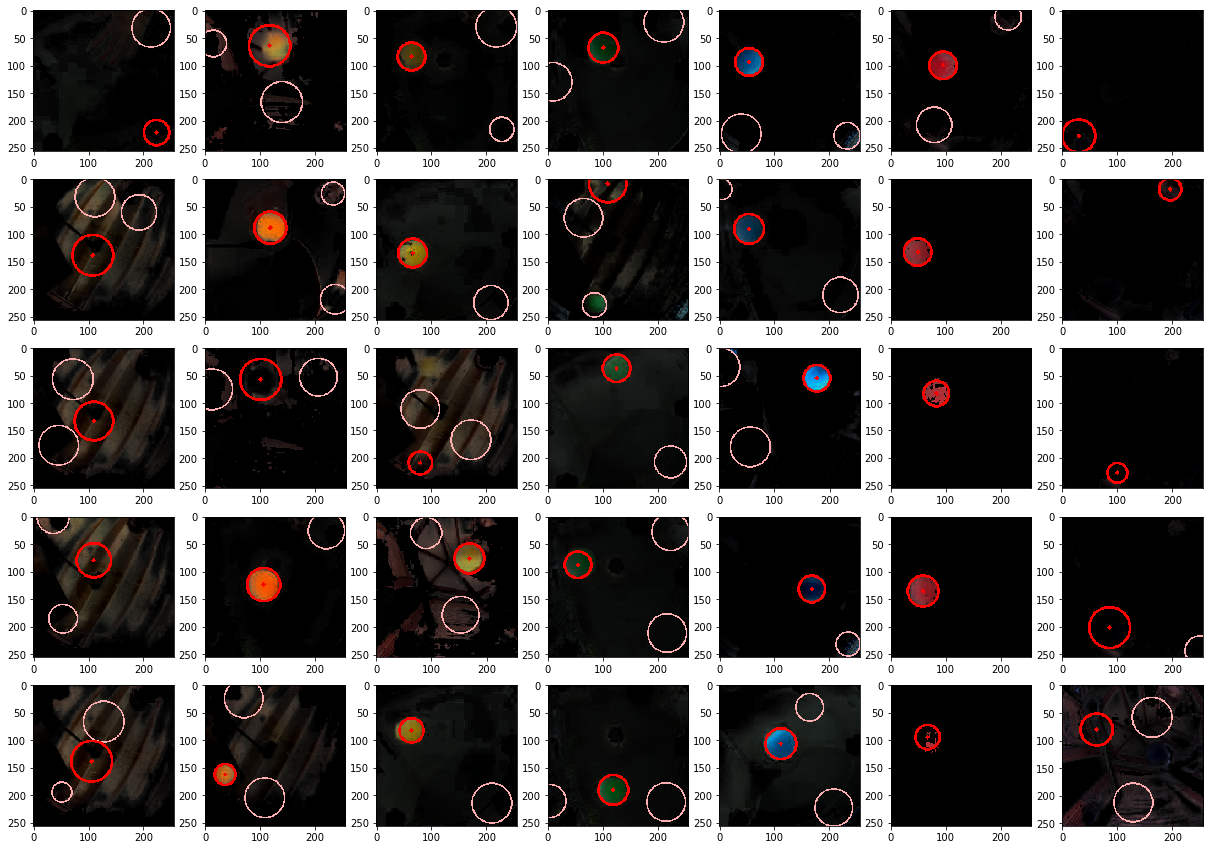

In [25]:
fig = plt.figure(figsize=(m * 3, n * 3))
frame_size = 256

""" # Run the image processing algorithm with given hyperparams.
    #     - param1:     First method-specific parameter. In case of HOUGH_GRADIENT and
    #                   It is the higher threshold of the two
    #                   passed to the Canny edge detector (the lower one is twice
    #                   smaller). 
    #     - param2:     Second method-specific parameter. In case of HOUGH_GRADIENT,
    #                   it is the accumulator threshold for the circle centers at the
    #                   detection stage. The smaller it is, the more false circles may
    #                   be detected. Circles, corresponding to the larger accumulator
    #                   values, will be returned first.

    # """

hough_kwargs = {
    "dp": 1,
    "min_dist": int(0.3 * frame_size),
    "param1": 150,
    "param2": 1,
    "min_radius": int(0.07 * frame_size),
    "max_radius": int(0.15 * frame_size),
}

run_detector(
    process_image_hough,
    m,
    n,
    use_mask,
    use_soft_mask,
    display_mask,
    display_circles,
    max_circles,
    blur,
    **hough_kwargs
)

## Run Dilation (Original) detector

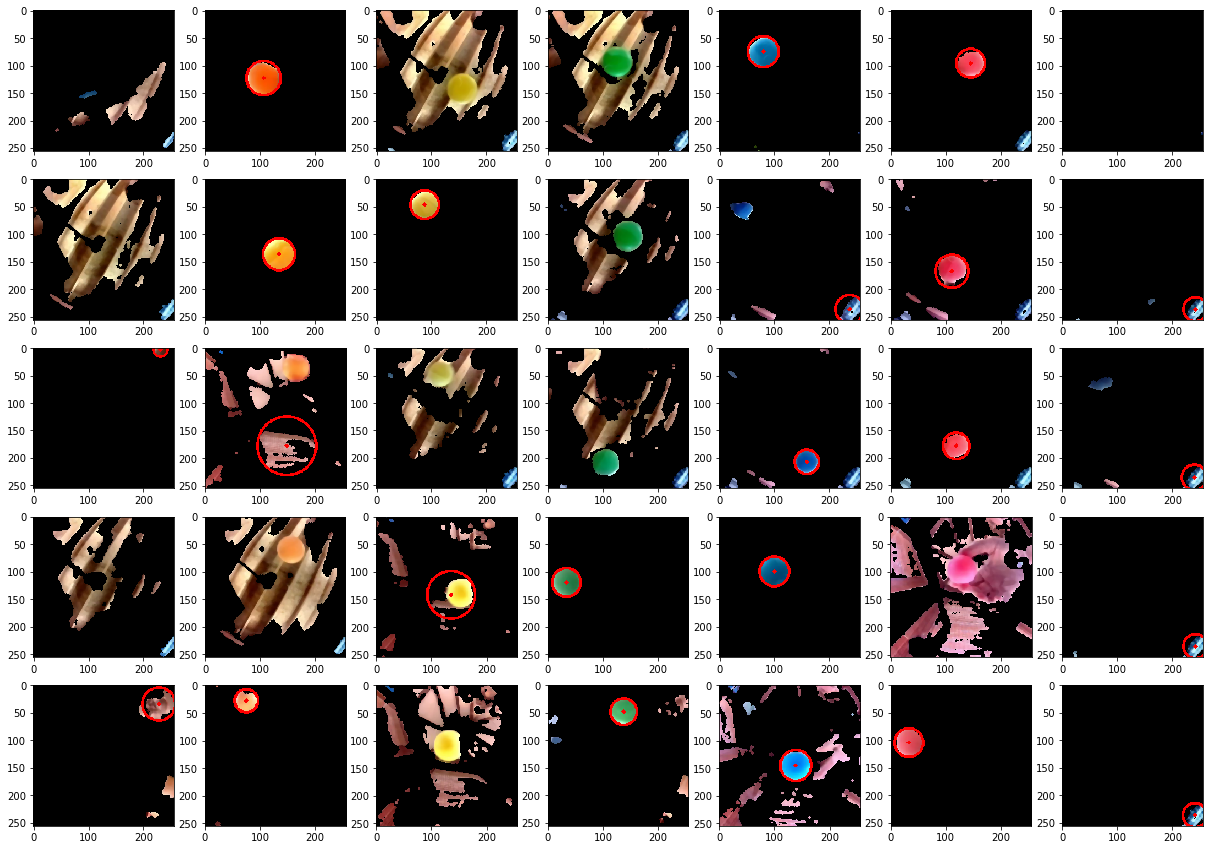

In [26]:
fig = plt.figure(figsize=(m * 3, n * 3))
frame_size = 256

dilation_kwargs = {
    "frame_size": 256,
    "ball_min": 0.03,
    "ball_max": 0.22,
    "draw_contours": False,
}


use_mask = True
use_soft_mask = False

run_detector(
    process_image_dilation,
    m,
    n,
    use_mask,
    use_soft_mask=use_soft_mask,
    display_mask=display_mask,
    display_circles=display_circles,
    max_circles=max_circles,
    blur=5,
    hue_sigma=0.1,
    gain=60.0,
    mask_gain=1.0,
    **dilation_kwargs
)

use_mask = True
use_soft_mask = True

## Run Blob detector

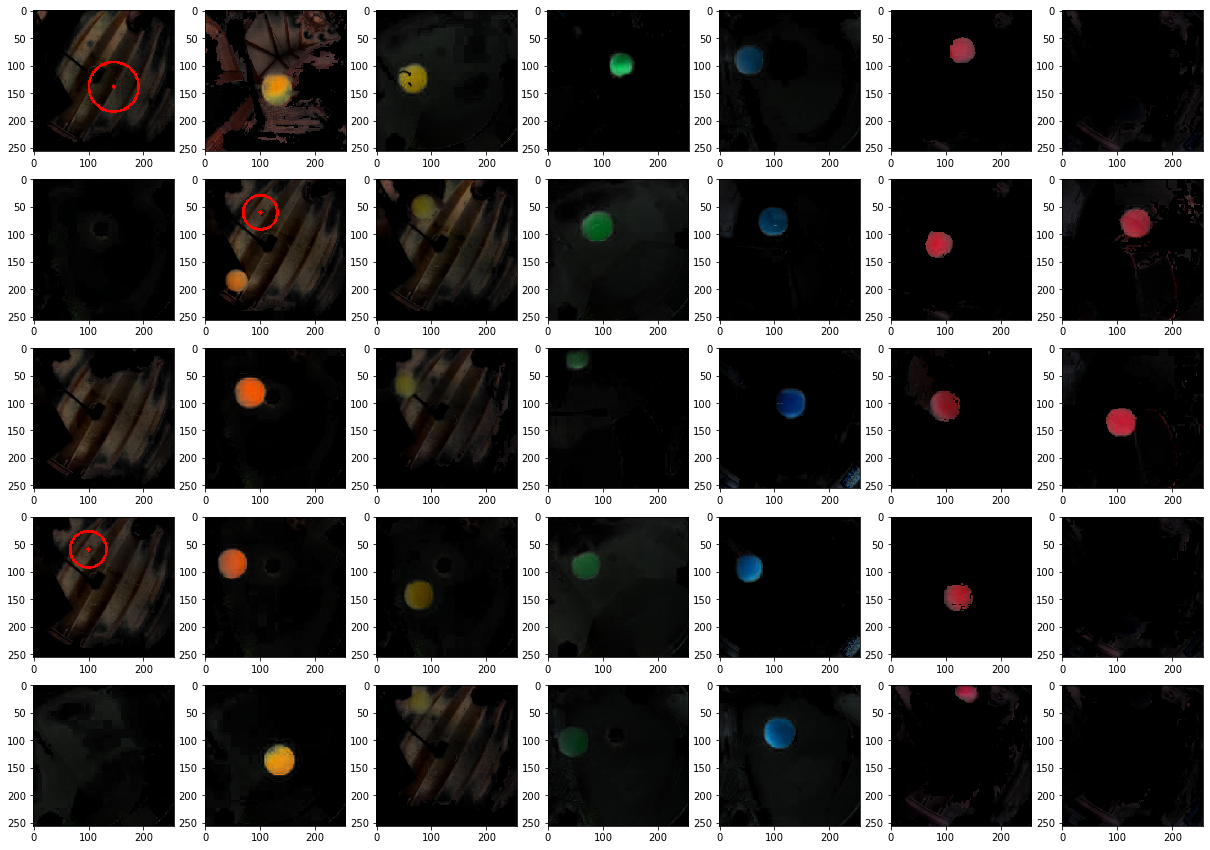

In [27]:
fig = plt.figure(figsize=(m * 3, n * 3))

params = cv2.SimpleBlobDetector_Params()  # Setup SimpleBlobDetector parameters.
params.minThreshold = 10  # Change thresholds
params.maxThreshold = 400
params.filterByArea = True  # Filter by Area.
params.minArea = 500
params.filterByCircularity = True  # Filter by Circularity
params.minCircularity = 0.1
params.filterByConvexity = False  # Filter by Convexity
params.minConvexity = 0.87
params.filterByInertia = False  # Filter by Inertia
params.minInertiaRatio = 0.01
detector = cv2.SimpleBlobDetector_create(params)

blob_kwargs = {
    "detector": detector,
}

use_soft_mask = False

run_detector(
    process_image_blob,
    m,
    n,
    use_mask,
    display_mask,
    display_circles,
    max_circles,
    blur,
    **blob_kwargs
)